In [2]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import ( accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score)



In [3]:
from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
TrainingArguments,
Trainer,
ViTImageProcessor,
ViTForImageClassification,
DefaultDataCollator
)

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import(
CenterCrop,
RandomRotation,
RandomResizedCrop,
RandomHorizontalFlip,
RandomAdjustSharpness,
Resize,
ToTensor,
Normalize,
Compose)

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
image_dict={}

from pathlib import Path
from tqdm import tqdm
import os

file_names= []
labels = []

for file in sorted(Path('Dataset').glob('*/*.*')):
    label = file.parent.name  # Gets 'AI' or 'real'
    labels.append(label)
    file_names.append(str(file))

print(len(file_names), len(labels))

df = pd.DataFrame.from_dict({"image": file_names, "label":labels})
print(df.shape)


3203 3203
(3203, 2)


In [6]:
df.head()

,image,label
0,Dataset\AI\0_20241130135552_A_close-up_shot_of...,AI
1,Dataset\AI\100_20241130141829_A_close-up_shot_...,AI
2,Dataset\AI\101_20241130141840_A_close-up_shot_...,AI
3,Dataset\AI\102_20241130141854_A_close-up_shot_...,AI
4,Dataset\AI\103_20241130141904_A_close-up_shot_...,AI


In [7]:
df['label'].unique()

array(['AI', 'real'], dtype=object)

In [8]:
y=df[['label']]

df = df.drop(['label'], axis=1)

ros = RandomOverSampler(random_state=83)

df, y_resampled = ros.fit_resample(df, y)

del y
df['label'] = y_resampled

del y_resampled

gc.collect()

print(df.shape)

(4404, 2)


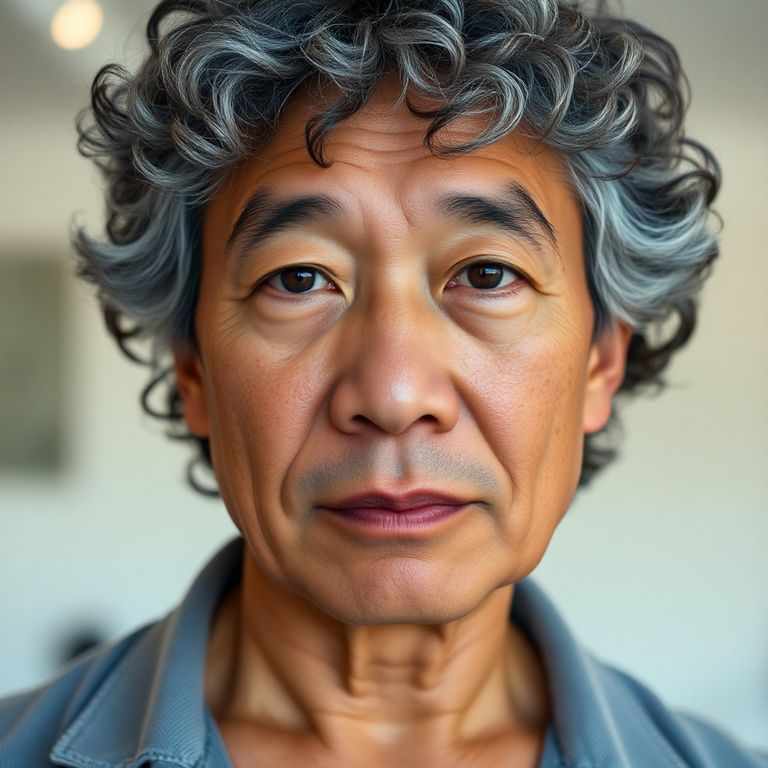

In [9]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

dataset[0]["image"]

In [10]:
labels_subset = labels[:5]
print(labels_subset)

['AI', 'AI', 'AI', 'AI', 'AI']


In [11]:
labels_list = ['real', 'AI']

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label]= i
    id2label[i]=label

print("Mapping of IDs to labels:", id2label, "\n")
print("Mapping of labels to IDs:", label2id)

Mapping of IDs to labels: {0: 'real', 1: 'AI'} 

Mapping of labels to IDs: {'real': 0, 'AI': 1}


In [12]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] =ClassLabels.str2int(example['label'])
    return example
 
dataset = dataset.map(map_label2id, batched=True)

dataset= dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset["train"]
test_data= dataset["test"]



Map:   0%|          | 0/4404 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4404 [00:00<?, ? examples/s]

In [13]:

model_str= "dima806/deepfake_vs_real_image_detection"
processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)

normalize= Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [Resize((size,size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize
    ]

)

_val_transforms = Compose(
    [
        Resize((size,size)),
        ToTensor(),
        normalize
        ]
    
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [14]:
train_data.set_transform(train_transforms)

test_data.set_transform(val_transforms) 

In [15]:
def collate_fn(examples):
    
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    labels = torch.tensor([example['label'] for example in examples])

    return {"pixel_values": pixel_values, "labels" : labels}

In [16]:
import torch
print("CUDA available:", torch.cuda.is_available())


CUDA available: False


In [17]:
train_data = train_data.with_transform(train_transforms)
test_data = test_data.with_transform(val_transforms)


In [18]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True))

85800194


In [19]:
import transformers
import accelerate

print(transformers.__version__)  # Should be >= 4.30
print(accelerate.__version__)   # Should be >= 0.21.0


4.51.3
1.7.0


In [32]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }


model_name = "deepfake_vs_real_image_detection"

num_train_epochs = 0.1
print(transformers.__version__)

from transformers import TrainingArguments

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',

    learning_rate=1e-6,

    per_device_eval_batch_size=8,
    per_device_train_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,

    remove_unused_columns=False,
    save_strategy='epoch',
    eval_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)


4.51.3


In [33]:
trainer =Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor 
)

In [34]:
help(ToTensor)

Help on class ToTensor in module torchvision.transforms.transforms:

class ToTensor(builtins.object)
 |  ToTensor() -> None
 |
 |  Convert a PIL Image or ndarray to tensor and scale the values accordingly.
 |
 |  This transform does not support torchscript.
 |
 |  Converts a PIL Image or numpy.ndarray (H x W x C) in the range
 |  [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
 |  if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
 |  or if the numpy.ndarray has dtype = np.uint8
 |
 |  In the other cases, tensors are returned without scaling.
 |
 |  .. note::
 |      Because the input image is scaled to [0.0, 1.0], this transformation should not be used when
 |      transforming target image masks. See the `references`_ for implementing the transforms for image masks.
 |
 |  .. _references: https://github.com/pytorch/vision/tree/main/references/segmentation
 |
 |  Methods defined here:
 |
 |  __call__(self, pic)
 |     

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.517903,0.614075


TrainOutput(global_step=34, training_loss=1.4587815228630514, metrics={'train_runtime': 2176.3559, 'train_samples_per_second': 0.121, 'train_steps_per_second': 0.016, 'total_flos': 2.1077821175169024e+16, 'train_loss': 1.4587815228630514, 'epoch': 0.1027190332326284})

In [36]:
trainer.evaluate()

{'eval_loss': 1.517903208732605,
 'eval_accuracy': 0.6140749148694665,
 'eval_runtime': 641.4568,
 'eval_samples_per_second': 2.747,
 'eval_steps_per_second': 0.345,
 'epoch': 0.1027190332326284}

In [39]:
outputs = trainer.predict(test_data)

In [40]:
print(outputs.metrics)

{'test_loss': 1.517903208732605, 'test_accuracy': 0.6140749148694665, 'test_runtime': 646.8823, 'test_samples_per_second': 2.724, 'test_steps_per_second': 0.342}


In [42]:
model.save_pretrained("model")
processor.save_pretrained("model")


['model\\preprocessor_config.json']